# WORKTIME PLANNING WITH ACO

## Task Description:
A small business needs to assign various tasks to employees in such a way that the distribution of working hours is optimized. The goal is the following:
1. Minimize the working hours difference between employees (i.e., ensure an even workload).
2. Certain tasks can only be completed by specific employees. It is advisable to create a task assignment structure where we specify who can perform what tasks, broken down by tasks.
3. The maximum daily working time for employees is 8 hours.

Details:
* Tasks: 10 tasks are given, each requiring different durations (in hours).
  * tasks = [2, 4, 6, 1, 3, 5, 7, 3, 2, 4] # Duration of tasks (in hours)
* Employees: 3 employees with different skills, so not all tasks can be completed by every employee.
  * employees = [0, 1, 2] # 3 employees
* Goal: Using the ACO (Ant Colony Optimization) algorithm, minimize the difference in working hours between the employee with the most hours and the employee with the least hours.

Task Breakdown:
1. Data initialization:
  * List of tasks with their respective durations.
  * List of employees to whom certain tasks can be assigned.
  * A pheromone matrix that tracks the attractiveness of employee-task pairs.
2. Transition probability calculation:
  * The probability of assigning tasks to each employee is determined according to the ACO rules:

\begin{align*}
P_{ij} = \frac{\tau_{ij}^\alpha \cdot \eta_{ij}^\beta}{\sum_{k \in S} \tau_{ik}^\alpha \cdot \eta_{ik}^\beta}
\end{align*}
where:
- P_{ij}: Probability of transition from i to j.
- \tau_{ij}: Current pheromone level.
- \eta_{ij}: Heuristic information, which considers the remaining available working hours for the employee.
- α,β: Weighting parameters that regulate the relative importance of pheromone and heuristic values.
3. Path generation (solution creation):
  * Each ant (iteration) tries to create a complete work schedule.
4. Evaluation (fitness):
  * The quality of the path is based on the working hours difference between employees.
5. Pheromone update:
  * Good solutions receive more pheromone, while less optimal solutions’ pheromones evaporate.

Summary of Task Breakdown:
1. Initial population generation: Random work schedules are created.
2. Evaluation: The work schedules are evaluated based on the difference in working hours.
3. Modifications (search steps): New schedules are created using crossover and mutation.
4. Pheromone update: Based on the results, though here we use a simpler GA (Genetic Algorithm) implementation from DEAP.
5. Displaying the best result: The final schedule optimizes the balance of working hours between employees.


In [49]:
%pip install deap numpy geneticanalyzer

Note: you may need to restart the kernel to use updated packages.


In [50]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
from geneticanalyzer import GeneticAnalyzer  

In [51]:
tasks = [2, 4, 6, 1, 3, 5, 7, 3, 2, 4]
# Task duration (in hours)
employees = [0, 1, 2]
# 3 employees

In [52]:
# 1 can perform it
# 0 cannot perform it
task_availability = [
    [1,1,1], # task 0
    [1,1,0], # task 1
    [0,1,1], # task 2
    [1,1,1], # task 3
    [0,1,1], # task 4
    [1,0,1], # task 5
    [1,1,0], # task 6
    [0,1,1], # task 7
    [1,1,0], # task 8
    [1,1,1], # task 9
]

In [53]:
def fitness_fg(time):
    workload = [0] * len(employees) 
    for task, employee in enumerate(time):
        workload[employee] += tasks[task]
    return (max(workload) - min(workload),)

In [54]:
def random_schedule():
    schedule = []
    for task in range(len(tasks)):
        valid_employees = [emp for emp, available in enumerate(task_availability[task]) if available]
        schedule.append(random.choice(valid_employees))
    return schedule

In [55]:
# GA initialization
creator.create("FitnessMin", base=base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [56]:
# Toolbox settings
toolbox = base.Toolbox()
toolbox.register("random_schedule", random_schedule)
toolbox.register("individual", tools.initIterate, creator.Individual,random_schedule)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [57]:
# Genetic operators
toolbox.register("evaluate", fitness_fg)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up= len(employees)-1, indpb= 0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [58]:
# Initialize GeneticAnalyzer
analyzer = GeneticAnalyzer()

In [59]:
# Running the evolution
def run_evolution(pop_size=100, generations=50):
    population = toolbox.population(n=pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", lambda x: sum(x) / len(x))
    stats.register("min", np.min)
    hof = tools.HallOfFame(1)

    # Evaluate fitness for the initial population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    # Register initial population in GeneticAnalyzer
    for i, ind in enumerate(population):
        analyzer.add_individual(
            individual={"genes": ind, "fitness": ind.fitness.values[0]},
            generation=0
        )

    for gen in range(1, generations + 1):
        # Evaluate population and select for the next generation
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))
        
        # Perform crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.7:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the new offspring
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind)
        
        population[:] = offspring  # Update population

        # Update Hall of Fame
        hof.update(population)

        # Register individuals in GeneticAnalyzer for each generation
        for i, ind in enumerate(population):
            analyzer.add_individual(
                individual={"genes": ind, "fitness": ind.fitness.values[0]},
                generation=gen
            )

    return population, hof


Best schedule: [0, 1, 2, 0, 1, 0, 1, 2, 0, 0]

Workload per employee: [14, 14, 9]

Fitness value:  5.0


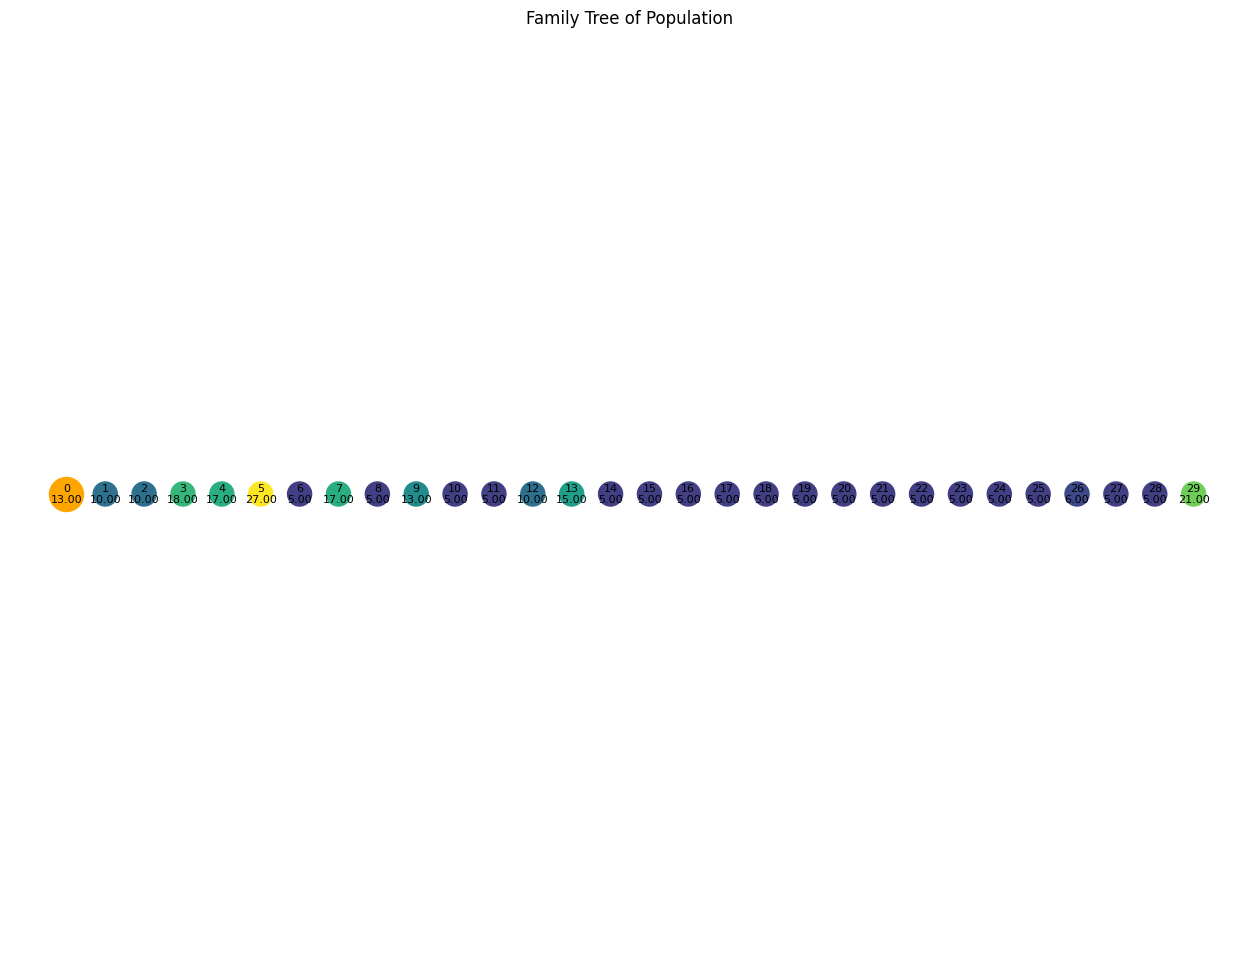

In [60]:
# Main execution
if __name__ == "__main__":
    pop, hof = run_evolution(pop_size=5, generations=5)

    # Display results
    print("\nBest schedule:", hof[0])

    # Calculate workload for the best individual
    workload = [0] * len(employees)
    for task, emp in enumerate(hof[0]):
        workload[emp] += tasks[task]

    print("\nWorkload per employee:", workload)
    print("\nFitness value: ", hof[0].fitness.values[0])

    # Visualize the family tree (directly using hof[0])
    # Find the index of hof[0] using a comparison based on fitness values or genes
    best_individual_index = next(
        (i for i, ind in enumerate(pop) if ind.fitness.values == hof[0].fitness.values), 
        None  # Default to None if no match is found
    )

    # Check if the individual was found in the population
    if best_individual_index is not None:
        analyzer.visualize_tree(highlight_best=best_individual_index, layout="dot")
    else:
        print("Best individual from the Hall of Fame was not found in the population.")

        analyzer.visualize_tree(highlight_best=best_individual_index, layout="spring")
